# Классификация последовательностей (текстов) при помощи RNN

## Import

In [ ]:
%%capture
!pip show torchtext
!pip install torchtext==0.6.0
# spacy -- вспомогательная библоитека для токенизации текста, скачаем токенайзер для английского языка
!pip install spacy
!python -m spacy download en_core_web_sm

In [ ]:
import pandas as pd
import torch
from torch import nn
import torchtext
from torchtext import data
from torchtext.datasets import IMDB
from torchtext.data import Field, LabelField

In [ ]:
class TextClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings=25002,
        embedding_size=300,
        hidden_size=200,
        num_classes=2,
        num_layers=1,
    ):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (last_hidden, last_c) = self.lstm(embedded)
        return self.linear(last_hidden[0]).squeeze()


model = TextClassifier()

In [ ]:
model(torch.tensor([[1, 2, 3, 4], [1, 2, 3, 4]]))

tensor([-0.1105, -0.1105], grad_fn=<SqueezeBackward0>)

In [ ]:
text_field = Field(
    tokenize="spacy",
    batch_first=True,
    include_lengths=False,
    tokenizer_language="en_core_web_sm",
)

label_field = LabelField(dtype=torch.float32, batch_first=True)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Создадим два сплита нашего датасета. Они задаются при помощи метода splits.

In [ ]:
data_train, data_test = IMDB.splits(text_field, label_field)

In [ ]:
vars(data_train[0]).get('label')

'pos'

Создадим также словари, соответствующие нашему тексту. Выкинем все слова (токены), которые встречаются редко. Оставим только 25 тысяч самых частых слов.

Также согласуем номера токенов в словаре с эмбеддингами glove. При желании можно согласовать и с word2vec'ом, но имейте ввиду, что glove это их аналог. Об инициализации эмбеддингов мы обязательно поговорим чуть позже.

In [ ]:
vocab_size = 25000

# build_vocab -- создать словарь по данному полю в датасете
text_field.build_vocab(
    data_train,
    max_size=vocab_size,
    vectors="glove.6B.100d",
)

label_field.build_vocab(data_train)

for item in data_train:
    print(item.text)
    break

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:32<00:00, 12492.39it/s]


['A', 'top', 'notch', 'Columbo', 'from', 'beginning', 'to', 'end', '.', 'I', 'particularly', 'like', 'the', 'interaction', 'between', 'Columbo', 'and', 'the', 'killer', ',', 'Ruth', 'Gordon.<br', '/><br', '/>As', 'an', 'avid', 'Columbo', 'fan', ',', 'I', 'ca', "n't", 'recall', 'another', 'one', 'in', 'which', 'he', 'does', "n't", 'set', 'up', 'the', 'killer', 'at', 'the', 'end', 'as', 'he', 'does', 'in', 'other', 'episodes', '.', 'In', 'this', 'one', ',', 'as', 'he', "'s", 'trying', 'to', 'determine', 'the', 'correct', 'sequence', 'of', 'the', 'boxes', 'and', 'the', '"', 'message', '"', 'that', 'the', 'nephew', 'left', 'behind', ',', 'it', 'finally', 'dawns', 'on', 'him.<br', '/><br', '/>The', 'music', 'in', 'this', 'episode', 'is', 'very', 'good', 'as', 'well', ',', 'as', 'it', 'is', 'in', 'many', 'of', 'other', 'ones', '.']


Выведите 10 самых часто встречающихся токенов в словаре.
Какой токен третий по частоте встречаемости?

In [ ]:
from collections import Counter
ds = Counter(data_train[0].text).most_common(10)
ds

[('the', 8),
 (',', 5),
 ('in', 4),
 ('as', 4),
 ('Columbo', 3),
 ('.', 3),
 ('he', 3),
 ('to', 2),
 ('end', 2),
 ('I', 2)]

Сделаем аналог даталоадера.

In [ ]:
train_dataloader, test_dataloader = data.BucketIterator.splits(
    (data_train, data_test), batch_size=32, device="cuda:0"
    )

Возьмите любой батч из train_dataloader. Чему равна самая первая размерность тензора, описывающего поле `text` в батче?

In [ ]:
next(iter(train_dataloader)).text.shape

torch.Size([32, 1009])

Длина текста около 1000 символов это очень много для нашей маленькой модельки. Будем обрезать их на 256 токенах в нашем трейн лупе.

In [ ]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cuda:0",
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])  # .reshape((0, ))
    total_labels = np.array([])  # .reshape((0, ))

    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for item in data_loader:
            reviews = item.text
            labels = item.label

            # Move Batch to GPU
            reviews = reviews.to(device)
            labels = labels.to(device)
            predicted = model(reviews)
            loss = criterion(predicted, labels)

            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Update descirption for tqdm
            accuracy = (predicted == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(
                total_predictions, (predicted > 0.5).int().cpu().detach().numpy()
            )
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())

    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, criterion, device="cuda:0"):

    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])

    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for reviews, labels in data_loader:
            reviews = reviews.to(device)
            labels = labels.to(device)
            predicted = model(reviews)

            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()

            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(
                total_predictions, predicted.argmax(1).cpu().detach().numpy()
            )
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1

    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics

## Задание 6

Запустите обучение модели. Чему равен loss на третьей по счету эпохе?

Оставьте в значении loss два знака после запятой, остальные отбросьте.

In [ ]:
import sys

import numpy as np
from tqdm.notebook import tqdm

device = "cuda:0"
model = TextClassifier()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

for i in range(10):
    train_epoch(
        model, train_dataloader, criterion=criterion, optimizer=optimizer, device=device
    )

Кажется, обучается так себе. Давайте это исправлять!

Попробуем сделать следующее:

* сделаем модель двунаправленной

* добавим DropOut

* инициализируем эмбеддинги GloVe векторами

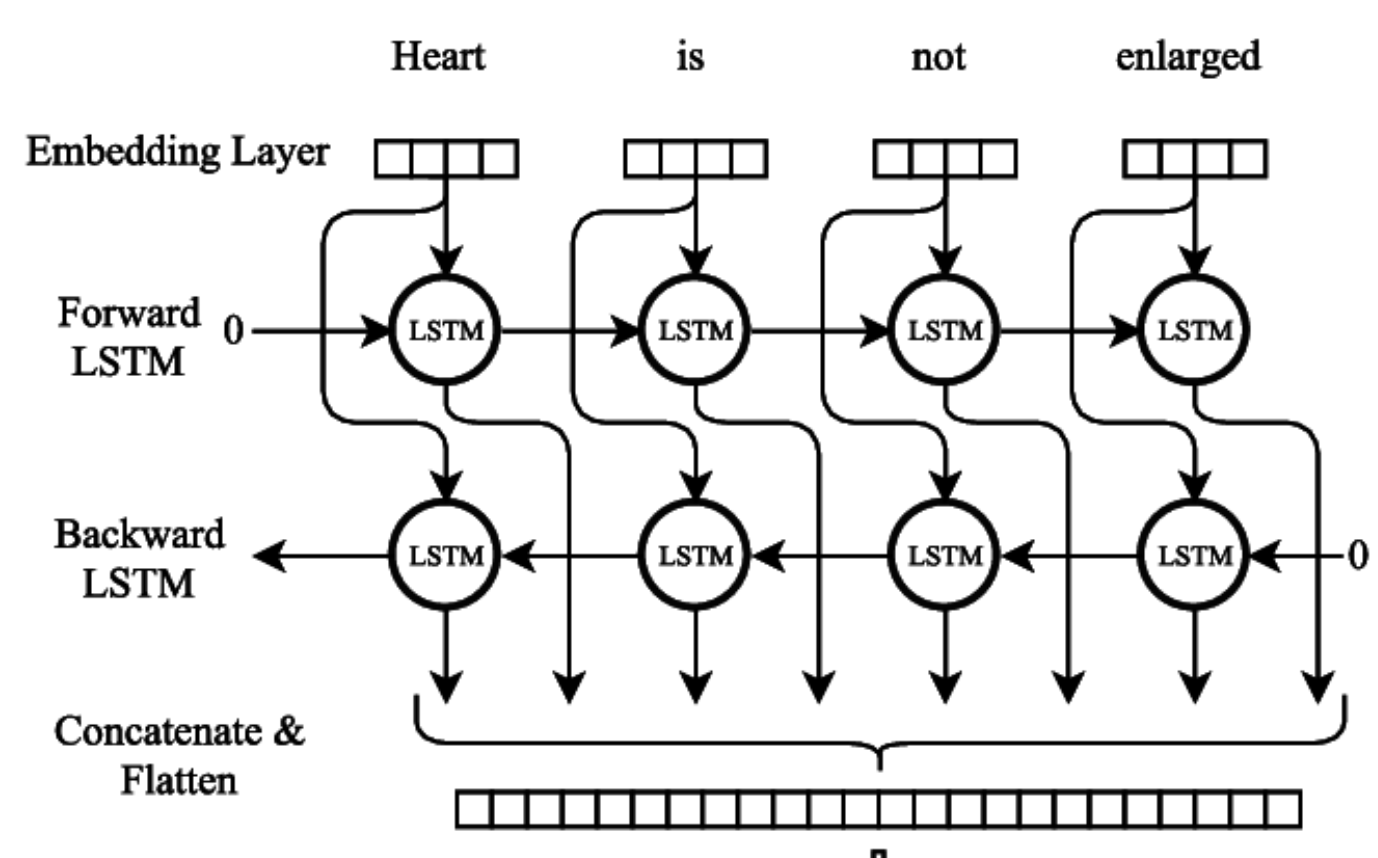

## Задание 7

Заполните метод `forward` класса `ModernTextClassifier`.

Запустите обучение модели.

In [ ]:
class ModernTextClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings=25002,
        embedding_size=300,
        hidden_size=200,
        num_classes=2,
        num_layers=1,
        pad_token=1,
    ):
        super(ModernTextClassifier, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings, embedding_size, padding_idx=pad_token
        )
        self.lstm = nn.LSTM(
            embedding_size,
            hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=True,
        )
        self.linear = nn.Linear(hidden_size * num_layers, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (last_hidden, last_c) = self.lstm(embedded)
        x = self.linear(last_hidden[0]).reshape(16, 1024)
        x = self.dropout(x)
        return x


device = "cuda:0"
pad_token = text_field.vocab.stoi["<pad>"]
model = ModernTextClassifier(
    hidden_size=512, embedding_size=100, num_layers=2, pad_token=pad_token
)
model.embedding.weight.data = text_field.vocab.vectors

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.BCEWithLogitsLoss()

for i in range(10):
    train_epoch(
        model, train_dataloader, criterion=criterion, optimizer=optimizer, device=device
    )

model(torch.tensor([[1, 2, 3, 4], [1, 2, 3, 4]]))